# Clustering & Segmenting Neighborhoods in Toronto

### Introduction

The purpose of this notebook is to segment and cluster neigborhoods in Toronto's M postal codes area. I will perfrom a webscraping of wikipedia to get list of neigborhoods, postal codes and borough in Toronto. I will do a  data wrangling on the data and transform it into a desired presentable format.
I will be using k-means algorithm to cluster and group the neighborhoods. And will finally use Folium library to visualize the neighborhoods and their respective clusters.

### Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 2>

1. <a href="#item1">Extract and Explore Dataset</a>

    
2. <a href="#item2">Generate Geocodes</a>

    
3. <a href="#item3">Clustering and Segmenting</a>
    
  3.1 <a href="#item4">Analyze Each Neighborhood</a>

  3.2 <a href="#item5">Cluster Neighborhoods</a>

  3.3 <a href="#item6">Examine Clusters</a> 
    

</font>
</div>

Importing required libraries

In [17]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup
import requests

import csv

print('libraries imported')

libraries imported


## 1. Extract and Explore Dataset

Extracting list of neigborhoods and postal code from wikipedia

In [19]:
url=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(url, 'lxml')

After inspecting the file, it became obvious that our interest is in the 'tr' tags under the 'table' tags 
Next let's view tr tags

#### Viewing the tags

In [20]:
#table=soup.find('table')
#print(table.prettify()) 
trtags=soup('tr')
trtags

[<tr>
 <th>Postcode</th>
 <th>Borough</th>
 <th>Neighbourhood
 </th></tr>, <tr>
 <td>M1A</td>
 <td>Not assigned</td>
 <td>Not assigned
 </td></tr>, <tr>
 <td>M2A</td>
 <td>Not assigned</td>
 <td>Not assigned
 </td></tr>, <tr>
 <td>M3A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
 </td></tr>, <tr>
 <td>M4A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
 </td></tr>, <tr>
 <td>M5A</td>
 <td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
 <td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
 </td></tr>, <tr>
 <td>M6A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
 </td></tr>, <tr>
 <td>M6A</td>
 <td><a href="/wiki/North_Yor

Extracting and viewing the table

In [21]:
tableau = soup.find('table', class_="wikitable sortable")

for table_row in tableau.find_all('tr'):
    row = table_row.text.splitlines()
    try:
        post_code=row[1]
        Borough_= row[2]
        Neighbour_hood=row[3]
    except:
        None
    
    if None: continue
    
   
    print(post_code, Borough_, Neighbour_hood)

Postcode Borough Neighbourhood
M1A Not assigned Not assigned
M2A Not assigned Not assigned
M3A North York Parkwoods
M4A North York Victoria Village
M5A Downtown Toronto Harbourfront
M6A North York Lawrence Heights
M6A North York Lawrence Manor
M7A Downtown Toronto Queen's Park
M8A Not assigned Not assigned
M9A Queen's Park Not assigned
M1B Scarborough Rouge
M1B Scarborough Malvern
M2B Not assigned Not assigned
M3B North York Don Mills North
M4B East York Woodbine Gardens
M4B East York Parkview Hill
M5B Downtown Toronto Ryerson
M5B Downtown Toronto Garden District
M6B North York Glencairn
M7B Not assigned Not assigned
M8B Not assigned Not assigned
M9B Etobicoke Cloverdale
M9B Etobicoke Islington
M9B Etobicoke Martin Grove
M9B Etobicoke Princess Gardens
M9B Etobicoke West Deane Park
M1C Scarborough Highland Creek
M1C Scarborough Rouge Hill
M1C Scarborough Port Union
M2C Not assigned Not assigned
M3C North York Flemingdon Park
M3C North York Don Mills South
M4C East York Woodbine Heights


#### Creating a Dataframe of the table

In [22]:
# define the dataframe columns
column_names = ['Postcode', 'Borough', 'Neighborhood']

# instantiate the dataframe
Toronto = pd.DataFrame(columns=column_names)

#creating the dataframe
for table_row in tableau.find_all('tr'):
    trow=table_row.text.strip()
    row = table_row.text.splitlines()
    if trow.startswith('Postcode'): continue
    try:
        post_code=row[1]
        Borough_= row[2]
        Neighbour_hood=row[3]
    except:
        None
    if Borough_== 'Not assigned': continue   #ignore rows with not assigned borough
    if Neighbour_hood == 'Not assigned':     #giving borough name to neighborhood without a name
        Neighbour_hood = Borough_
    
    Toronto = Toronto.append({'Postcode': post_code,
                          'Borough': Borough_,
                          'Neighborhood': Neighbour_hood,
                         }, ignore_index=True)
print(Toronto.head(10))

  Postcode           Borough      Neighborhood
0      M3A        North York         Parkwoods
1      M4A        North York  Victoria Village
2      M5A  Downtown Toronto      Harbourfront
3      M6A        North York  Lawrence Heights
4      M6A        North York    Lawrence Manor
5      M7A  Downtown Toronto      Queen's Park
6      M9A      Queen's Park      Queen's Park
7      M1B       Scarborough             Rouge
8      M1B       Scarborough           Malvern
9      M3B        North York   Don Mills North


#### Grouping the data set so that each unique postal code becomes a row

In [23]:
grouped_df = Toronto.groupby(['Postcode', 'Borough']).agg({'Neighborhood':'unique'})
grouped_df.head()

,,Neighborhood
Postcode,Borough,
M1B,Scarborough,"[Rouge, Malvern]"
M1C,Scarborough,"[Highland Creek, Rouge Hill, Port Union]"
M1E,Scarborough,"[Guildwood, Morningside, West Hill]"
M1G,Scarborough,[Woburn]
M1H,Scarborough,[Cedarbrae]


#### Cleaning and making the table more presentable

In [24]:
def str_list(x):
    return x.str.cat(sep=', ')

grouped = Toronto.groupby(['Postcode', 'Borough']).agg({'Neighborhood':str_list})

# reset the index
grouped.reset_index(inplace=True)

# rename columns
grouped.columns = ['Postcode', 'Borough', 'Neighborhood']

grouped.head(15)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


What does our dataframe looks like in summary?

In [25]:
print('This Toronto neighborhood dataframe has {} boroughs, {} postal codes and {} neighborhoods.'.format(
        len(Toronto['Borough'].unique()),
        len(Toronto['Postcode'].unique()),
        Toronto.shape[0]
    )
)

This Toronto neighborhood dataframe has 11 boroughs, 103 postal codes and 210 neighborhoods.


In [26]:
grouped.shape

(103, 3)

## 2. Generating Geocodes

In [27]:
#!pip install geocoder
!conda install -c conda-forge geocoder
import geocoder # import geocoder

print('library imported')

Solving environment: done

# All requested packages already installed.

library imported


Viewing the postal code column

In [28]:
toronto_neborhood=pd.DataFrame(grouped)
toronto_neborhood['Postcode'].head()

0    M1B
1    M1C
2    M1E
3    M1G
4    M1H
Name: Postcode, dtype: object

Generating the Geocode of each postal code in the dataframe

Downloading the postal code file with latitude and longitude to continue with the analysis

In [29]:
path='http://cocl.us/Geospatial_data'
toronto_geodata=pd.read_csv(path)
toronto_geodata.head(15)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [30]:
toronto_geodata.shape

(103, 3)

Adding the latitude and longitude to the dataframe

In [31]:
toronto_neborhood['Latitude']=toronto_geodata['Latitude']
toronto_neborhood['Longitude']=toronto_geodata['Longitude'] 

#Viewing the new dataframe
toronto_neborhood.head(15)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


# 3. Clustering and Segmenting

Downloading all dependencies

In [32]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         673 KB

The following NEW packages will be INSTALLED:

    altair:  4.0.1-py_0 conda-forge
    branca:  0.3.1-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


altair-4.0.1         | 575 KB    | ##################################### | 1

#### Using geopy library to get the latitude and longitude values of Toronto.

In [33]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


#### Creating map of Toronto using latitude and longitude values

In [34]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_neborhood['Latitude'], toronto_neborhood['Longitude'], 
                                           toronto_neborhood['Borough'], toronto_neborhood['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Utilizing the Foursquare API to explore the neighborhoods and segment them.

Defining Foursquare Credentials and Version

In [35]:
# The code was removed by Watson Studio for sharing.

CLIENT_ID, CLIENT_SECRET & VERSION Processed


Viewing postcode and neighborhood

In [36]:
toronto_neborhood.loc[:, ['Postcode', 'Neighborhood']]

,Postcode,Neighborhood
0,M1B,"Rouge, Malvern"
1,M1C,"Highland Creek, Rouge Hill, Port Union"
2,M1E,"Guildwood, Morningside, West Hill"
3,M1G,Woburn
4,M1H,Cedarbrae
5,M1J,Scarborough Village
6,M1K,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,"Clairlea, Golden Mile, Oakridge"
8,M1M,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,"Birch Cliff, Cliffside West"


Let's explore postal code M1P (index 10)

Getting the selected neighborhood latitude and longitude

In [37]:
neighborhood_latitude = toronto_neborhood.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_neborhood.loc[10, 'Longitude'] # neighborhood longitude value
neighborhood_name = toronto_neborhood.loc[10, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Dorset Park, Scarborough Town Centre, Wexford Heights are 43.7574096, -79.27330400000001.


#### Next, let's get the top 100 venues that are in the neighborhood within a radius of 500 meters.

In [38]:
search_query='M1P'
radius=500
LIMIT=100


url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)


results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e3a306df7706a001b2f713c'},
 'response': {'headerLocation': 'Dorset Park',
  'headerFullLocation': 'Dorset Park, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 43.761909604500005,
    'lng': -79.26708530848985},
   'sw': {'lat': 43.7529095955, 'lng': -79.27952269151017}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5226562611d2cd49d83ef03b',
       'name': 'Kairali',
       'location': {'address': '1210 Kennedy Road',
        'crossStreet': 'Lawrence',
        'lat': 43.754914739291834,
        'lng': -79.27694504646365,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.754914739291834,
          'lng': -79.27694504646365}],
        'distance': 40

#### Extracting the category of the venue

In [39]:
#Creating a function to extract the category name
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Cleaning the json and structure it into a *pandas* dataframe.

In [40]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Kairali,Indian Restaurant,43.754915,-79.276945
1,Kim Kim restaurant,Chinese Restaurant,43.753833,-79.276611
2,Karaikudi Chettinad South Indian Restaurant,Indian Restaurant,43.756042,-79.276276
3,Big Al's Pet Supercentre,Pet Store,43.759279,-79.278325
4,Pho Vietnam,Vietnamese Restaurant,43.757770,-79.278572


Number of venues returned by Foursquare

In [41]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


### Explore the Neighborhoods in Toronto

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
       
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            #v['venue']['location']['postalCode'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

#### Creating a new dataframe called *toronto_venues*.

In [43]:
toronto_venues = getNearbyVenues(names=toronto_neborhood['Neighborhood'],
                                   latitudes=toronto_neborhood['Latitude'],
                                   longitudes=toronto_neborhood['Longitude'])

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [44]:
print(toronto_venues.shape)
toronto_venues.head()

(2216, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


Let's view the number of venues per neighborhood

In [45]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",12,12,12,12,12,12
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Downsview North, Wilson Heights",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,55,55,55,55,55,55


## 3.1 Analyze Each Neighborhood

In [46]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
#toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

Examining the new shape of the new dataframe

In [47]:
toronto_onehot.shape

(2216, 266)

#### Grouping rows by neigborhood and examining the mean of each occurrence

In [48]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.020000,0.000000,0.00,0.010000,0.000000,0.030000,0.000000,0.0000,0.000000,0.000000,0.000000,0.030000,0.000000,0.040000,0

#### Viewing the new dataframe size

In [49]:
toronto_grouped.shape

(100, 266)

#### Printing each neighborhood along with the top 5 most common venues

In [50]:
num_top_venues = 5

for neborhood in toronto_grouped['Neighborhood']:
    print("----"+neborhood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == neborhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.07
1               Bar  0.04
2        Steakhouse  0.04
3              Café  0.04
4  Asian Restaurant  0.03


----Agincourt----
                       venue  freq
0             Breakfast Spot  0.25
1                     Lounge  0.25
2  Latin American Restaurant  0.25
3               Skating Rink  0.25
4         Miscellaneous Shop  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
           venue  freq
0     Playground  0.33
1    Coffee Shop  0.33
2           Park  0.33
3    Men's Store  0.00
4  Metro Station  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                 venue  freq
0        Grocery Store  0.17
1          Pizza Place  0.08
2          Coffee Shop  0.08
3  Japanese Restaurant  0.08
4       Discount Store  0.08


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place

#### Let's put that into a *pandas* dataframe

In [51]:
# write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Bakery,Thai Restaurant,Burger Joint,Breakfast Spot,Cosmetics Shop,Asian Restaurant
1,Agincourt,Breakfast Spot,Latin American Restaurant,Skating Rink,Lounge,Yoga Studio,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Coffee Shop,Park,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Japanese Restaurant,Fast Food Restaurant,Liquor Store,Discount Store,Pharmacy,Coffee Shop,Sandwich Place
4,"Alderwood, Long Branch",Pizza Place,Pub,Gym,Pharmacy,Skating Rink,Coffee Shop,Sandwich Place,Pool,Athletics & Sports,Yoga Studio


In [53]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Bakery,Thai Restaurant,Burger Joint,Breakfast Spot,Cosmetics Shop,Asian Restaurant
1,Agincourt,Breakfast Spot,Latin American Restaurant,Skating Rink,Lounge,Yoga Studio,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Coffee Shop,Park,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Japanese Restaurant,Fast Food Restaurant,Liquor Store,Discount Store,Pharmacy,Coffee Shop,Sandwich Place
4,"Alderwood, Long Branch",Pizza Place,Pub,Gym,Pharmacy,Skating Rink,Coffee Shop,Sandwich Place,Pool,Athletics & Sports,Yoga Studio
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Bridal Shop,Ice Cream Shop,Supermarket,Bank,Deli / Bodega,Restaurant,Middle Eastern Restaurant,Fried Chicken Joint,Frozen Yogurt Shop
6,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Yoga Studio
7,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Fast Food Restaurant,Sandwich Place,Pharmacy,Café,Sushi Restaurant,Indian Restaurant,Butcher,Liquor Store
8,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Seafood Restaurant,Beer Bar,Steakhouse,Farmers Market,Vegetarian / Vegan Restaurant
9,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,Café,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


## Cluster the Nieghborhoods

Generating the best fit k for the kmeans algorithm using Sum of Square distance method

In [54]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

In [55]:
Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

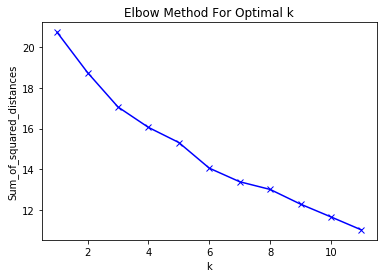

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The practice is to pick the k at the elbow. In this analysis it's 7

### Using the kmeans algorithm to cluster the neighborhood

In [57]:
# set number of clusters
k = 7

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:105] 

array([0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       6, 5, 0, 4, 0, 0, 2, 0, 6, 0, 3, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [58]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_neborhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(20) # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3.0,Fast Food Restaurant,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,History Museum,Bar,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio,Dessert Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Pizza Place,Breakfast Spot,Electronics Store,Medical Center,Rental Car Location,Mexican Restaurant,Intersection,Doner Restaurant,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Caribbean Restaurant,Bakery,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Hakka Restaurant,Dumpling Restaurant,Drugstore
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,6.0,Playground,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,0.0,Discount Store,Department Store,Coffee Shop,Convenience Store,Drugstore,Dim Sum Restaurant,Diner,Dog Run,Doner Restaurant,Donut Shop
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,0.0,Bakery,Bus Line,Ice Cream Shop,Intersection,Bus Station,Soccer Field,Park,Metro Station,Eastern European Restaurant,Dumpling Restaurant
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,0.0,Motel,American Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio,Dessert Shop
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0.0,College Stadium,Skating Rink,Café,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


#### Dropping Neigborhood with no data i.e empty rows: 'M9B' & 'M1X'

In [59]:
toronto_merged=toronto_merged.dropna()
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head(20)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3,Fast Food Restaurant,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,History Museum,Bar,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio,Dessert Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Pizza Place,Breakfast Spot,Electronics Store,Medical Center,Rental Car Location,Mexican Restaurant,Intersection,Doner Restaurant,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Caribbean Restaurant,Bakery,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Hakka Restaurant,Dumpling Restaurant,Drugstore
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,6,Playground,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,0,Discount Store,Department Store,Coffee Shop,Convenience Store,Drugstore,Dim Sum Restaurant,Diner,Dog Run,Doner Restaurant,Donut Shop
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,0,Bakery,Bus Line,Ice Cream Shop,Intersection,Bus Station,Soccer Field,Park,Metro Station,Eastern European Restaurant,Dumpling Restaurant
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,0,Motel,American Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio,Dessert Shop
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0,College Stadium,Skating Rink,Café,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


### Viewing the cluster on the map

In [60]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)


# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Cluster 1

In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,0,History Museum,Bar,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio,Dessert Shop
2,Scarborough,0,Pizza Place,Breakfast Spot,Electronics Store,Medical Center,Rental Car Location,Mexican Restaurant,Intersection,Doner Restaurant,Diner,Discount Store
3,Scarborough,0,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
4,Scarborough,0,Caribbean Restaurant,Bakery,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Hakka Restaurant,Dumpling Restaurant,Drugstore
6,Scarborough,0,Discount Store,Department Store,Coffee Shop,Convenience Store,Drugstore,Dim Sum Restaurant,Diner,Dog Run,Doner Restaurant,Donut Shop
7,Scarborough,0,Bakery,Bus Line,Ice Cream Shop,Intersection,Bus Station,Soccer Field,Park,Metro Station,Eastern European Restaurant,Dumpling Restaurant
8,Scarborough,0,Motel,American Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio,Dessert Shop
9,Scarborough,0,College Stadium,Skating Rink,Café,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
10,Scarborough,0,Indian Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run
11,Scarborough,0,Middle Eastern Restaurant,Breakfast Spot,Smoke Shop,Bakery,Yoga Studio,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore


Cluster 2

In [62]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,1,Baseball Field,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
97,North York,1,Baseball Field,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore


Cluster 3

In [63]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,North York,2,Bank,Park,Convenience Store,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
25,North York,2,Park,Food & Drink Shop,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
31,North York,2,Grocery Store,Hotel,Bank,Park,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
44,Central Toronto,2,Park,Bus Line,Swim School,Construction & Landscaping,Yoga Studio,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
74,York,2,Park,Market,Women's Store,Fast Food Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
79,North York,2,Bakery,Park,Construction & Landscaping,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
90,Etobicoke,2,River,Park,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
98,York,2,Park,Convenience Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
100,Etobicoke,2,Sandwich Place,Park,Mobile Phone Shop,Bus Line,Yoga Studio,Doner Restaurant,Diner,Discount Store,Dog Run,Donut Shop


Cluster 3

In [64]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,3,Fast Food Restaurant,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


Cluster 4

In [65]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
102,Etobicoke,4,Rental Car Location,Drugstore,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop


Cluster 5

In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,North York,5,Piano Bar,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


Cluster 6

In [67]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,6,Playground,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
14,Scarborough,6,Playground,Coffee Shop,Park,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
30,North York,6,Playground,Airport,Park,Snack Place,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
48,Central Toronto,6,Tennis Court,Playground,Park,Trail,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
50,Downtown Toronto,6,Park,Playground,Trail,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
